# Homework 1 Solution

##### ECE471 - Fundamentals of Remote Sensing and Earth Observation
##### Summer IS 2022
##### Instructor: Krishna Karra

## Reproject & resample the input dataset

First, we need to pick a spatial reference system to resample to. I chose EPSG:32613 which is the UTM zone that covers most of New Mexico (and entirely overlaps Santa Fe). This puts the units of the data in meters.

The next step is to pick a resolution to resample all the data to. I've chosen to upsample all the data to 10 meters, which is the native resolution of the data for the RGBN bands. To minimze resampling artifacts, I chose the cubic resampler.

Finally, we need to clip the data to the provided cutline. This ensures that we have the same extent (bounds) for every image.

In [3]:
from glob import glob
import os
from tqdm.auto import tqdm

In [5]:
input_dir = './s2_santafe'
input_files = glob(os.path.join(input_dir, '*.tif'))
print(f"Found {len(input_files)} files to process")

Found 102 files to process


In [6]:
# define output CRS, resolution and resampler
t_srs = 'EPSG:32613'
tr = 10
r = 'cubic'

In [7]:
# define cutline to crop data
cutline = 'santafe_crop.geojson'

In [8]:
# create an output directory to hold corrected files
output_dir = './s2_santafe_fix'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
# reproject and resample each file
for input_file in tqdm(input_files):
    output_file = os.path.join(output_dir, os.path.basename(input_file))
    cmd = f"gdalwarp -co COMPRESS=LZW -t_srs {t_srs} -tr {tr} {tr} -r {r} -cutline {cutline} -crop_to_cutline {input_file} {output_file}"
    os.system(cmd)

  0%|          | 0/102 [00:00<?, ?it/s]

## Read in all the data

In [29]:
from datetime import datetime
import numpy as np
import rasterio

In [30]:
imagery_files = glob(os.path.join(output_dir, '*.tif'))
len(imagery_files)

102

In [31]:
# sort the files by date
def sort_by_date(f):
    date_str = f.split('_')[-1].replace('.tif', '')
    dtime = datetime.strptime(date_str, '%Y-%m-%d')
    return dtime

In [32]:
imagery_files = sorted(imagery_files, key=sort_by_date)

In [33]:
# define a function to read in a single image
def read_image_file(image_file):
    with rasterio.open(image_file) as src:
        data = src.read()
        
    # put the bands axis last, so it plays nicely with matplotlib
    data = np.transpose(data, axes=(1, 2, 0))
    
    # use the alpha band as a mask
    # wherever the alpha band is zero, data is invalid
    mask = data[:, :, -1] == 0
    
    # repeat for all six other bands
    mask = np.repeat(mask[..., np.newaxis], 6, axis=-1)
    
    # create a masked numpy array
    data = np.ma.array(data=data[:, :, :-1], mask=mask)
    
    return data

In [37]:
# read in all the imagery in a single shot
imagery = list()
for i in tqdm(imagery_files):
    image = read_image_file(i)
    imagery.append(image)

  0%|          | 0/102 [00:00<?, ?it/s]

In [38]:
# make it a masked stack
imagery = np.ma.stack(imagery)

In [39]:
imagery.shape

(102, 1744, 1745, 6)

## Write a function to plot an image

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# write a function to rescale an input image with percentile scaling
def rescale_img(img, min_val=0.0, max_val=1.0, dtype=np.float32, pmin=0.0, pmax=100.0, vmin=None, vmax=None):
    # compute min and max percentile ranges to scale with
    if not vmin:
        vmin, vmax = np.nanpercentile(img, pmin), np.nanpercentile(img, pmax)

    # rescale & clip
    img_rescale = ((img - vmin) * (1.0 / (vmax - vmin) * max_val)).astype(dtype)
    np.clip(img_rescale, min_val, max_val, out=img_rescale)

    return img_rescale

In [49]:
# write a function to plot an input TIF (RGB)
def plot_scene(img, title, pmin=1, pmax=99):
    # set the masked values to 0 for display
    img = img.filled(0)

    # do a default 1/99% rescale on the RGB imagery
    rgb = rescale_img(img[:, :, 0:3], pmin=pmin, pmax=pmax)

    # plot the image
    plt.figure(dpi=200)
    plt.axis('off')
    plt.title(title, fontsize=6)
    plt.imshow(rgb)
    plt.show()
    plt.close()

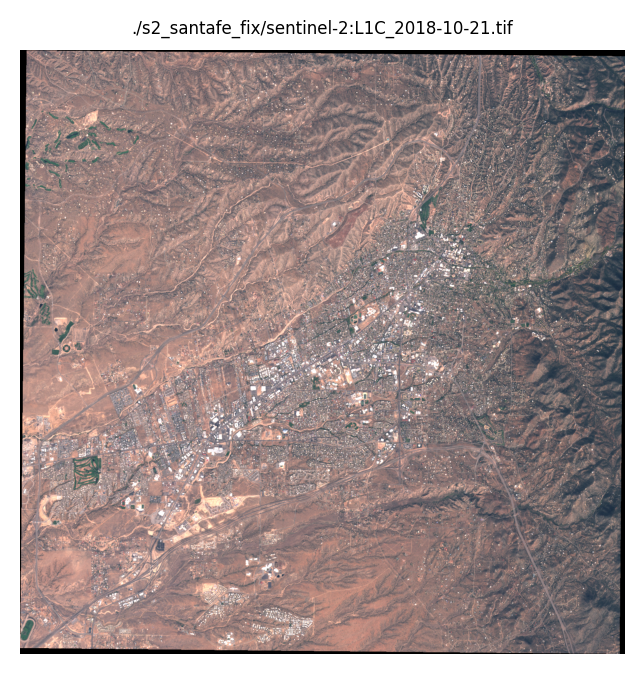

In [76]:
# spot check an image
plot_scene(imagery[-21, ...], imagery_files[-21], pmin=1, pmax=99)

## Compute a histogram across each band in the dataset

In [51]:
# define the bands in the input data
bands = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
n_bands = len(bands)

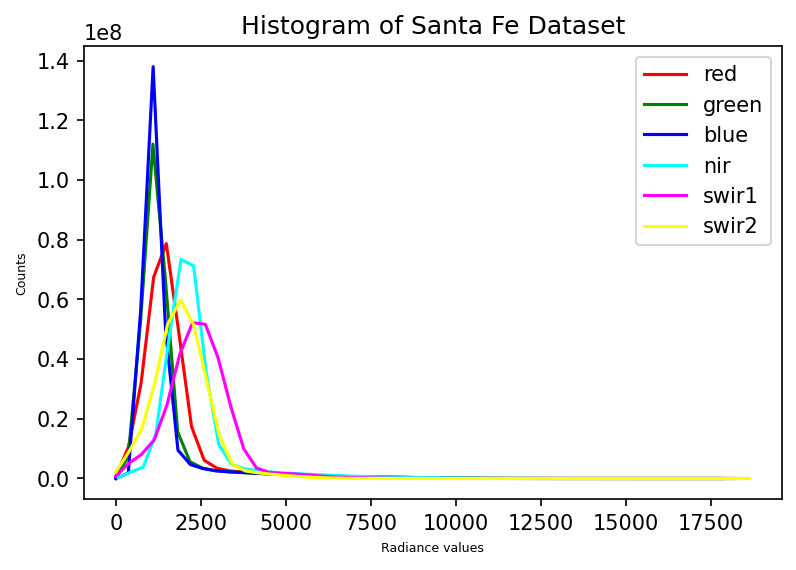

In [53]:
# compute the histogram across each band, and plot
n_bins = 50
plt.figure(dpi=150)
for bidx, band in enumerate(bands):
    hist, bins = np.histogram(imagery[:, :, :, bidx].compressed(), bins=n_bins)
    plt.plot(bins[:-1], hist, color=colors[bidx])
plt.legend(bands)
plt.xlabel('Radiance values', fontsize=6)
plt.ylabel('Counts', fontsize=6)
plt.title('Histogram of Santa Fe Dataset')
plt.show()
plt.close()